In [63]:
import os

nb_name = "nb20230626_190400_ACh_cueonset_response_change.ipynb" #TODO change this

basename, ext = os.path.splitext(nb_name)
input_path = os.path.join(os.getcwd(), nb_name)

!jupyter nbconvert "{input_path}" --to="python" --output="{basename}"

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230626_190400_ACh_cueonset_response_change.ipynb to python
[NbConvertApp] Writing 26500 bytes to d:\OneDrive - Nexus365\Private_Dropbox\Projects\trialexp\notebooks\noncanonical\nb20230626_190400_ACh_cueonset_response_change.py


based on notebooks\noncanonical\nb20230622_215600_ACh_cueonset_2_outcomes.ipynb


- Calculate the CC and linregress slope for ACh dip, rebound, and DA peak against trial_nb
- We should be able to find sessions in which ACh rebound stays while ACh dip goes away.
- By detecting slow trough in data, we could also find sessions with recovery
- Should we also analyse data around spount? Movement encoding may be more stable.
- We can use `lme4` for ACh dip etc.


- scatter plots for `trial_nb` against dip size etc 
- dip size
    - selected_data = xr_photometry['hold_for_water_zscored_df_over_f'].sel(trial_nb=k, event_time=slice(150, 300))
- rebound size
    - selected_data = xr_photometry['hold_for_water_zscored_df_over_f'].sel(trial_nb=k, event_time=slice(350, 700))


\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22\TT002-2023-06-22-111549\processed

- lots of abortions


In [ ]:
%reload_ext autoreload
%autoreload 2
import os
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import re
from matplotlib import pyplot as plt
import itertools
import seaborn as sns
import patchworklib as pw


from trialexp.process.pyphotometry.utils import *
from trialexp.process.pycontrol import event_filters
from trialexp.process.pycontrol.event_filters import extract_event_time
from trialexp.process.pyphotometry.utils import measure_ACh_dip_rebound, measure_DA_peak



# by_sessions_dir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions'
# task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')
# task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')
# data_dir = os.path.join(task_dir, 'TT002-2023-06-05-154932', 'processed')

# xr_photometry = xr.open_dataset(os.path.join(data_dir, 'xr_photometry.nc'))
# xr_session = xr.open_dataset(os.path.join(data_dir, 'xr_session.nc'))
# df_pycontrol = pd.read_pickle(os.path.join(data_dir, 'df_pycontrol.pkl'))
# df_events = pd.read_pickle(os.path.join(data_dir, 'df_events_cond.pkl'))


<Figure size 100x100 with 0 Axes>

In [ ]:


by_sessions_dir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions'
task_dir = os.path.join(by_sessions_dir,  'reaching_go_spout_bar_nov22')

items = os.listdir(task_dir)
data_dirs = [os.path.join(task_dir, item, 'processed') for item in items if os.path.isdir(os.path.join(task_dir, item))]
session_ids = [item for item in items if os.path.isdir(os.path.join(task_dir, item))]
subject_ids = [re.match(r"(\w+)-", ssid).group(1) for ssid in session_ids]


In [ ]:
## Test data

# data_dirs = [os.path.join(
#     task_dir, 'TT002-2023-06-05-154932', 'processed')]
# session_ids = [item for item in items if os.path.isdir(os.path.join(task_dir, item))]
# subject_ids = ['TT002']


# Compute ACh
3 m 47 s for the folder 'reaching_go_spout_bar_nov22' and the 5 mice

In [ ]:
subject_ids_ACh = ['TT001','TT002','TT005','RE606', 'RE607']

ind_ACh = [ind for ind, sbj in enumerate(subject_ids) if sbj in subject_ids_ACh]


In [ ]:

data = []

for dd, ss, sj in zip([data_dirs[i] for i in ind_ACh], [session_ids[i] for i in ind_ACh], [subject_ids[i] for i in ind_ACh]):

    df_trials, lin_regress_dip, lin_regress_rebound, lin_regress_dip_rebound, \
        is_success, msg = measure_ACh_dip_rebound(dd)
    n_trials = np.nan
    if isinstance(df_trials, pd.DataFrame):
        n_trials = df_trials.shape[0]
    row_data_list = [ss] + [sj] + [df_trials] + [n_trials] + list(lin_regress_dip.values()) + list(
        lin_regress_rebound.values()) + list(lin_regress_dip_rebound.values()) + [is_success] + [msg] + [dd]
    data.append(row_data_list)

df_ACh_cue_onset = pd.DataFrame(data)

df_ACh_cue_onset.columns = ['session_id', 'subject_id', 'df_trials', 'n_trials',
              'trial_nb_dip_slope', 'trial_nb_dip_intercept', 'trial_nb_dip_r_value', 'trial_nb_dip_p_value', 'trial_nb_dip_std_er',
              'trial_nb_rebound_slope', 'trial_nb_rebound_intercept', 'trial_nb_rebound_r_value', 'trial_nb_rebound_p_value', 'trial_nb_rebound_std_er',
              'dip_rebound_slope', 'dip_rebound_intercept', 'dip_rebound_r_value', 'dip_rebound_p_value', 'dip_rebound_std_er',
              'is_success', 'msg', 'data_dir']


In [ ]:

mask = (df_ACh_cue_onset['n_trials'].notnull()) & (df_ACh_cue_onset['n_trials'] > 100) & df_ACh_cue_onset['is_success']
df_ACh_cue_onset_100 = df_ACh_cue_onset.loc[mask]

df_ACh_cue_onset_100['n_trials']

0      107.0
1      201.0
2      209.0
3      142.0
4      371.0
       ...  
99     333.0
100    255.0
102    189.0
103    181.0
104    237.0
Name: n_trials, Length: 83, dtype: float64

# Compute DA


In [ ]:
subject_ids_DA = ['kms058','kms062','kms063','kms064', 'JC317L']

ind_DA = [ind for ind, sbj in enumerate(subject_ids) if sbj in subject_ids_DA]


In [ ]:
data = []

for dd, ss, sj in zip([data_dirs[i] for i in ind_DA], [session_ids[i] for i in ind_DA], [subject_ids[i] for i in ind_DA]):

    df_trials, lin_regress_pk, \
        is_success, msg = measure_DA_peak(dd)
    n_trials = np.nan
    if isinstance(df_trials, pd.DataFrame):
        n_trials = df_trials.shape[0]
    row_data_list = [ss] + [sj] + [df_trials] + [n_trials] + list(lin_regress_pk.values()) + [is_success] + [msg] + [dd]
    data.append(row_data_list)

df_DA_cue_onset = pd.DataFrame(data)

df_DA_cue_onset.columns = ['session_id', 'subject_id', 'df_trials', 'n_trials',
                            'trial_nb_pk_slope', 'trial_nb_pk_intercept', 'trial_nb_pk_r_value', 'trial_nb_pk_p_value', 'trial_nb_pk_std_er',
                            'is_success', 'msg', 'data_dir']


#'TT002-2023-06-05-154932',

print(df_ACh_cue_onset.trial_nb_dip_r_value)
print(df_ACh_cue_onset.trial_nb_rebound_r_value)
print(df_ACh_cue_onset.dip_rebound_r_value)

0    0.525112
Name: trial_nb_dip_r_value, dtype: float64
0   -0.29187
Name: trial_nb_rebound_r_value, dtype: float64
0    0.001605
Name: dip_rebound_r_value, dtype: float64


In [ ]:

mask = (df_DA_cue_onset['n_trials'].notnull()) & (
    df_DA_cue_onset['n_trials'] > 100) & df_DA_cue_onset['is_success']
df_DA_cue_onset_100 = df_DA_cue_onset.loc[mask]

df_DA_cue_onset_100['n_trials']


10     207.0
12     199.0
13     212.0
15     176.0
16     155.0
       ...  
130    163.0
131    180.0
132    210.0
133    131.0
135    115.0
Name: n_trials, Length: 78, dtype: float64

## Plotting style

In [ ]:


# Define your list of markers
markers = itertools.cycle(
    ('o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'))

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams["legend.frameon"] = False
plt.rcParams['xtick.bottom']=True
plt.rcParams['ytick.left']=True
plt.rcParams['font.family']= 'Arial'

plt.rcParams['axes.labelsize'] = 12


# ACh

Text(-0.8, -0.5, 'Decreasing in size')

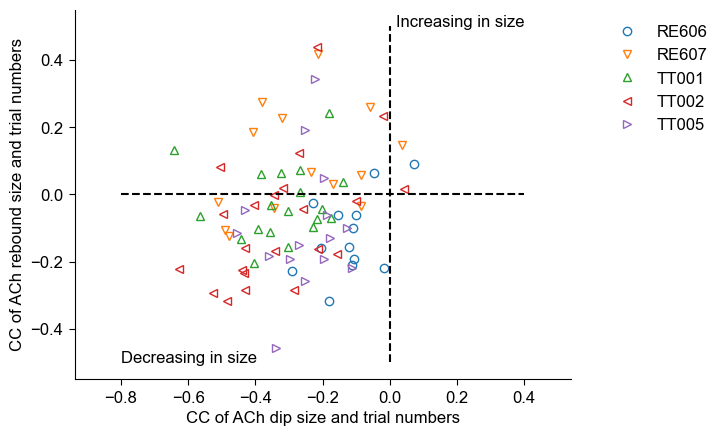

In [ ]:

fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for sbj in subject_ids_:
    x = - 1 * df_ACh_cue_onset_100['trial_nb_dip_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj]
    y = df_ACh_cue_onset_100['trial_nb_rebound_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj]

    ax.plot(x, y, marker=next(markers), linestyle='None', fillstyle='none', label = sbj)

plt.axis('equal')

# ax.set_xlim()
# ax.set_ylim()

ax.plot([-0.8, 0.4], [0, 0], '--k')
ax.plot([0, 0], [-0.5, 0.5],  '--k')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CC of ACh dip size and trial numbers')
plt.ylabel('CC of ACh rebound size and trial numbers')

# Negative CCs mean the absolute size of dip and rebound is reducing

ax.text(0.4, 0.5, 'Increasing in size', ha = 'right')
ax.text(-0.8, -0.5, 'Decreasing in size', ha = 'left')


In [ ]:
np.count_nonzero((df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < 0.1) &
                 (df_ACh_cue_onset_100['trial_nb_rebound_r_value'] > 0.1))


13

In [ ]:
# find sessions with CC for dip > 0.1, CC for rebound > 0.1

ss_dp = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < -0.2) & 
                          (df_ACh_cue_onset_100['trial_nb_rebound_r_value'] > 0.2) , 'session_id']

ss_dp



16    RE607-2023-05-24-103758
18    RE607-2023-05-26-121015
19    RE607-2023-05-28-163935
86    TT002-2023-07-03-143615
92    TT005-2023-05-29-131014
Name: session_id, dtype: object

In [ ]:
ss_rdp = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_rebound_r_value'] > 0.2), 'session_id']

ss_rdp


16    RE607-2023-05-24-103758
17    RE607-2023-05-25-104806
18    RE607-2023-05-26-121015
19    RE607-2023-05-28-163935
34    TT001-2023-05-29-135910
65    TT002-2023-05-25-124141
86    TT002-2023-07-03-143615
92    TT005-2023-05-29-131014
Name: session_id, dtype: object

In [ ]:
ss_dd = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < -0.2) &
                                 (df_ACh_cue_onset_100['trial_nb_rebound_r_value'] < -0.2), 'session_id']
ss_dd


4     RE606-2023-05-31-115641
38    TT001-2023-06-02-163605
66    TT002-2023-05-26-154844
67    TT002-2023-05-29-133612
68    TT002-2023-05-30-142840
73    TT002-2023-06-05-154932
74    TT002-2023-06-06-152000
75    TT002-2023-06-07-145802
78    TT002-2023-06-19-141706
89    TT005-2023-05-24-163108
98    TT005-2023-06-05-145911
Name: session_id, dtype: object

Text(0.5, 1.0, 'Average per animal')

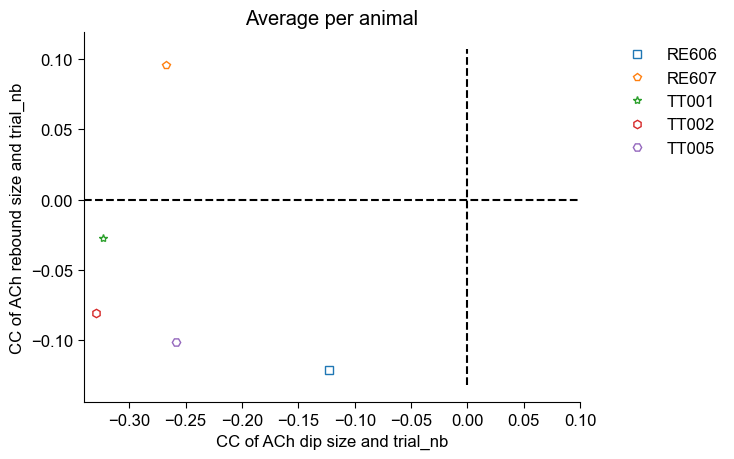

In [ ]:
fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for sbj in subject_ids_:
    x = -1 * np.mean(df_ACh_cue_onset_100['trial_nb_dip_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj])
    y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj])

    ax.plot(x, y, marker=next(markers), linestyle='None',
            fillstyle='none', label=sbj)


XLIM = ax.get_xlim()
ax.set_xlim([XLIM[0], 0.1])
XLIM = ax.get_xlim()

YLIM = ax.get_ylim()

ax.plot(XLIM, [0, 0], '--k')
ax.plot([0, 0], YLIM,  '--k')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('CC of ACh dip size and trial_nb')
plt.ylabel('CC of ACh rebound size and trial_nb')
plt.title('Average per animal')


Text(30.45833333333333, 0.5, 'CC of ACh dip size and trial number')

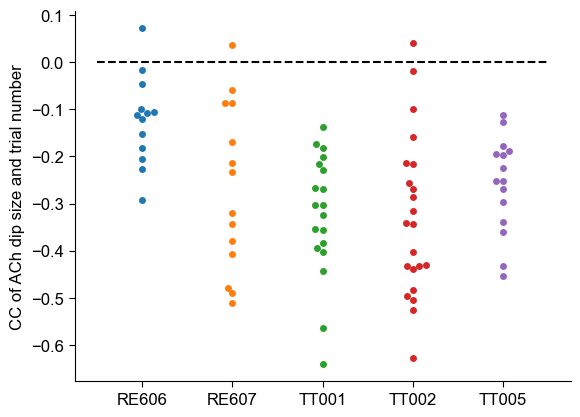

In [ ]:
fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for i, sbj in enumerate(subject_ids_):
    # minus means moving the other ways
    y = (df_ACh_cue_onset_100['trial_nb_dip_r_value']
         [df_ACh_cue_onset_100['subject_id'] == sbj]) * -1
    # y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_ACh_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)
plt.ylabel('CC of ACh dip size and trial number')


Text(30.45833333333333, 0.5, 'CC of ACh rebound size and trial number')

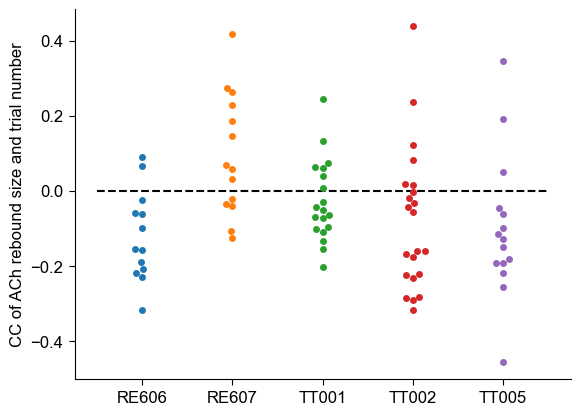

In [ ]:
fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for i, sbj in enumerate(subject_ids_):
    # minus means moving the other ways
    y = (df_ACh_cue_onset_100['trial_nb_rebound_r_value']
         [df_ACh_cue_onset_100['subject_id'] == sbj])
    # y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_ACh_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)
plt.ylabel('CC of ACh rebound size and trial number')


Text(30.45833333333333, 0.5, 'CC of DA peak size and trial number')

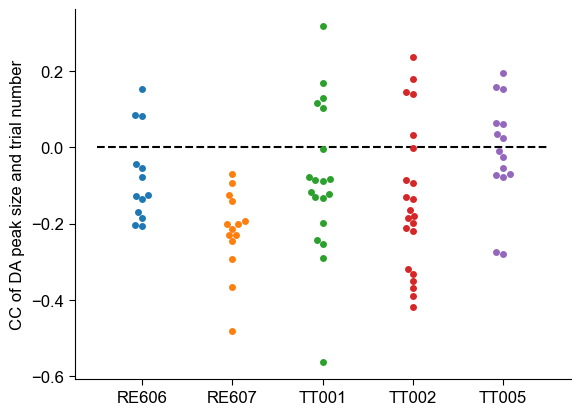

In [ ]:

fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for i, sbj in enumerate(subject_ids_):
    y = (df_ACh_cue_onset_100['dip_rebound_r_value'][df_ACh_cue_onset_100['subject_id'] == sbj]) * -1 # minus means moving the other ways
    # y = np.mean(df_ACh_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_ACh_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)
plt.ylabel('CC of DA peak size and trial number')


In [ ]:
sbj = 'kms058'

df_ACh_cue_onset_100.loc[df_ACh_cue_onset_100['subject_id'] == sbj].index
 


Int64Index([], dtype='int64')

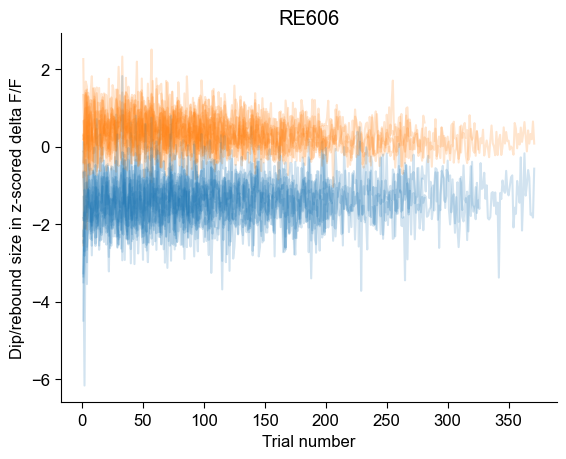

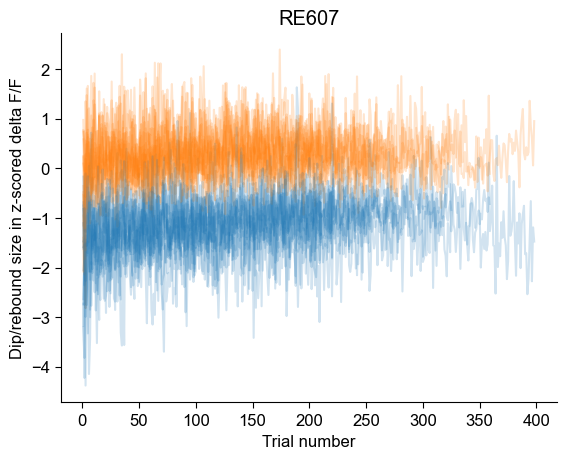

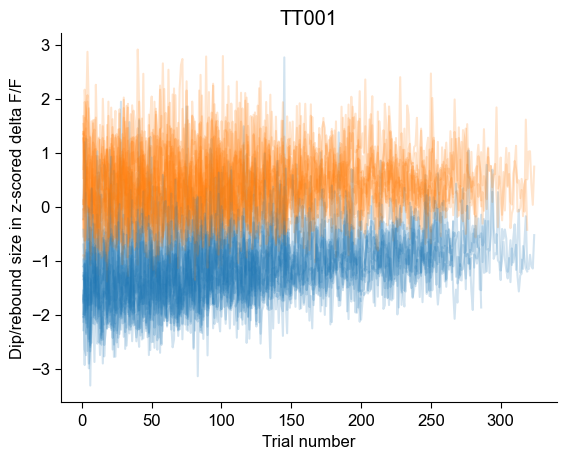

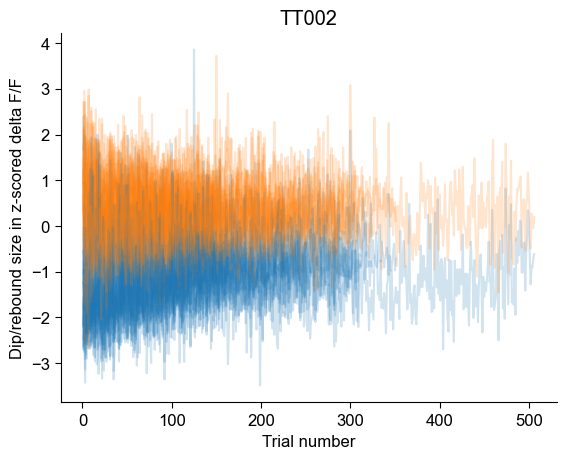

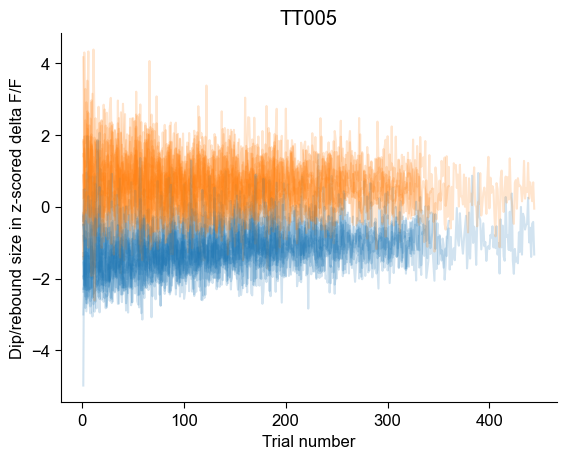

In [ ]:
subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for sbj in subject_ids_:

    fig, ax = plt.subplots()

    df_ACh_cue_onset_100['subject_id'] == sbj

    ax.set_title(sbj)

    ind = df_ACh_cue_onset_100.loc[df_ACh_cue_onset_100['subject_id'] == sbj].index

    for i in ind:
        
        ax.plot(df_ACh_cue_onset_100['df_trials'][i]['trial_nb'], 
                df_ACh_cue_onset_100['df_trials'][i]['dip'], color = '#1f77b4', alpha = 0.2)
        ax.plot(df_ACh_cue_onset_100['df_trials'][i]['trial_nb'],
                df_ACh_cue_onset_100['df_trials'][i]['rebound'], color='#ff7f0e', alpha = 0.2)
        
        ax.set_xlabel('Trial number')
        ax.set_ylabel('Dip/rebound size in z-scored delta F/F')


# DA

([<matplotlib.axis.XTick at 0x144dd2534f0>,
 [Text(0, 0, 'JC317L'),
  Text(1, 0, 'kms058'),
  Text(2, 0, 'kms062'),
  Text(3, 0, 'kms063'),
  Text(4, 0, 'kms064')])

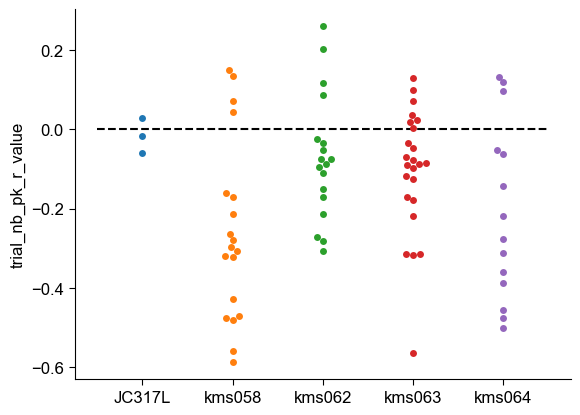

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()

subject_ids_ = sorted(list(set(df_DA_cue_onset_100['subject_id'])))

for i, sbj in enumerate(subject_ids_):
    y = (df_DA_cue_onset_100['trial_nb_pk_r_value']
         [df_DA_cue_onset_100['subject_id'] == sbj])
    # y = np.mean(df_DA_cue_onset_100['trial_nb_rebound_r_value']
    #             [df_DA_cue_onset_100['subject_id'] == sbj])

    sns.swarmplot(x=i, y=y)

    # ax.plot(x, marker=next(markers), linestyle='None',
    #         fillstyle='none', label=sbj)


ax.plot(ax.get_xlim(), [0, 0], '--k')

plt.xticks(range(0,5), subject_ids_)


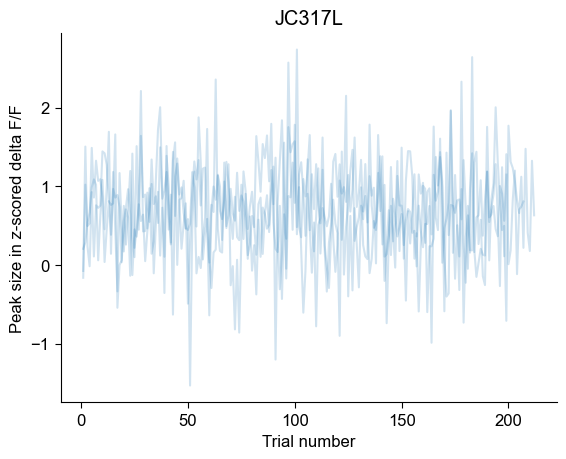

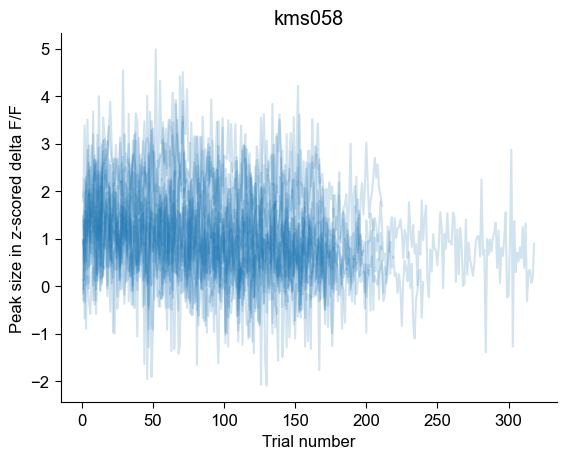

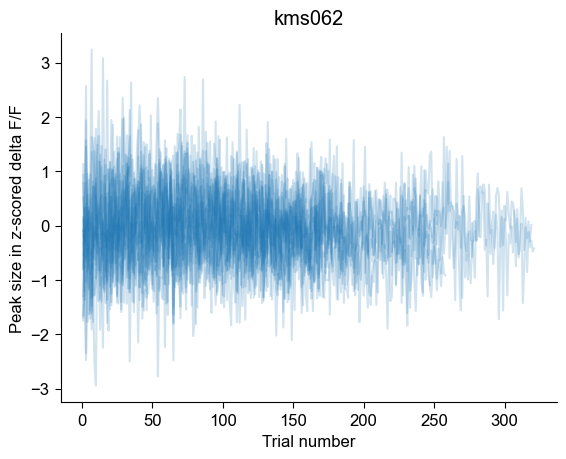

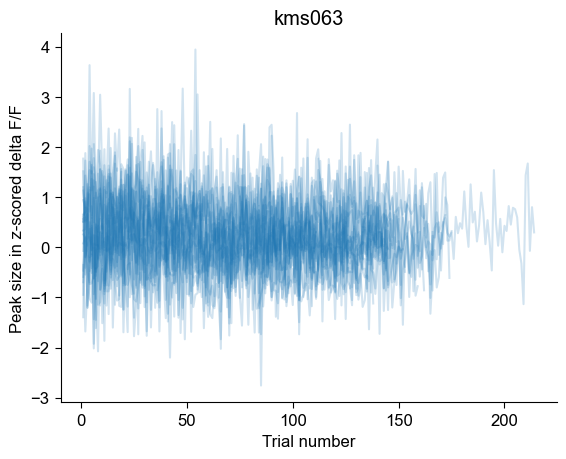

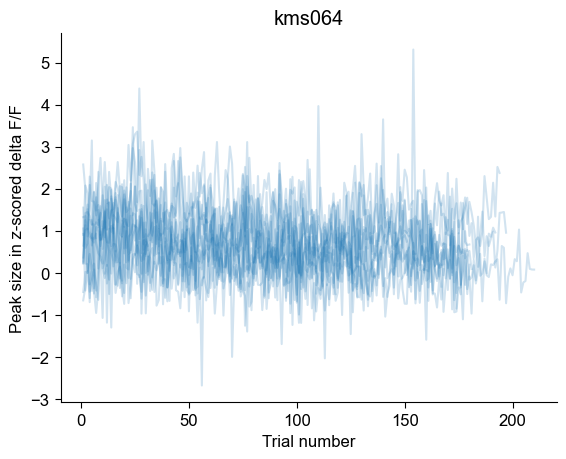

In [ ]:
subject_ids_ = sorted(list(set(df_DA_cue_onset_100['subject_id'])))

for sbj in subject_ids_:

    fig, ax = plt.subplots()

    df_DA_cue_onset_100['subject_id'] == sbj

    ax.set_title(sbj)

    ind = df_DA_cue_onset_100.loc[df_DA_cue_onset_100['subject_id'] == sbj].index

    for i in ind:
        
        ax.plot(df_DA_cue_onset_100['df_trials'][i]['trial_nb'], 
                df_DA_cue_onset_100['df_trials'][i]['peak'], color = '#1f77b4', alpha = 0.2)
        
        ax.set_xlabel('Trial number')
        ax.set_ylabel('Peak size in z-scored delta F/F')


# Moving average

Use moving average and detection of slow peak or trough in response size

```python
data['value_smooth'] = data['value'].rolling(window=5).mean()

```

I hoped to detect large scale change in response sizes, eg. a trough followed by rebound, implying they stopped performing and then engaged in the task again.

It's certainly less noisy, but 

In [ ]:

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

for sbj in subject_ids_:

    ind = df_ACh_cue_onset_100.loc[df_ACh_cue_onset_100['subject_id'] == sbj].index

    for i in ind:
        df_ACh_cue_onset_100.loc[i, 'df_trials']['dip_smooth20'] = \
            df_ACh_cue_onset_100.loc[i, 'df_trials']['dip'].rolling(window=20).mean()
        df_ACh_cue_onset_100.loc[i, 'df_trials']['rebound_smooth20'] = \
            df_ACh_cue_onset_100.loc[i, 'df_trials']['rebound'].rolling(window=20).mean()


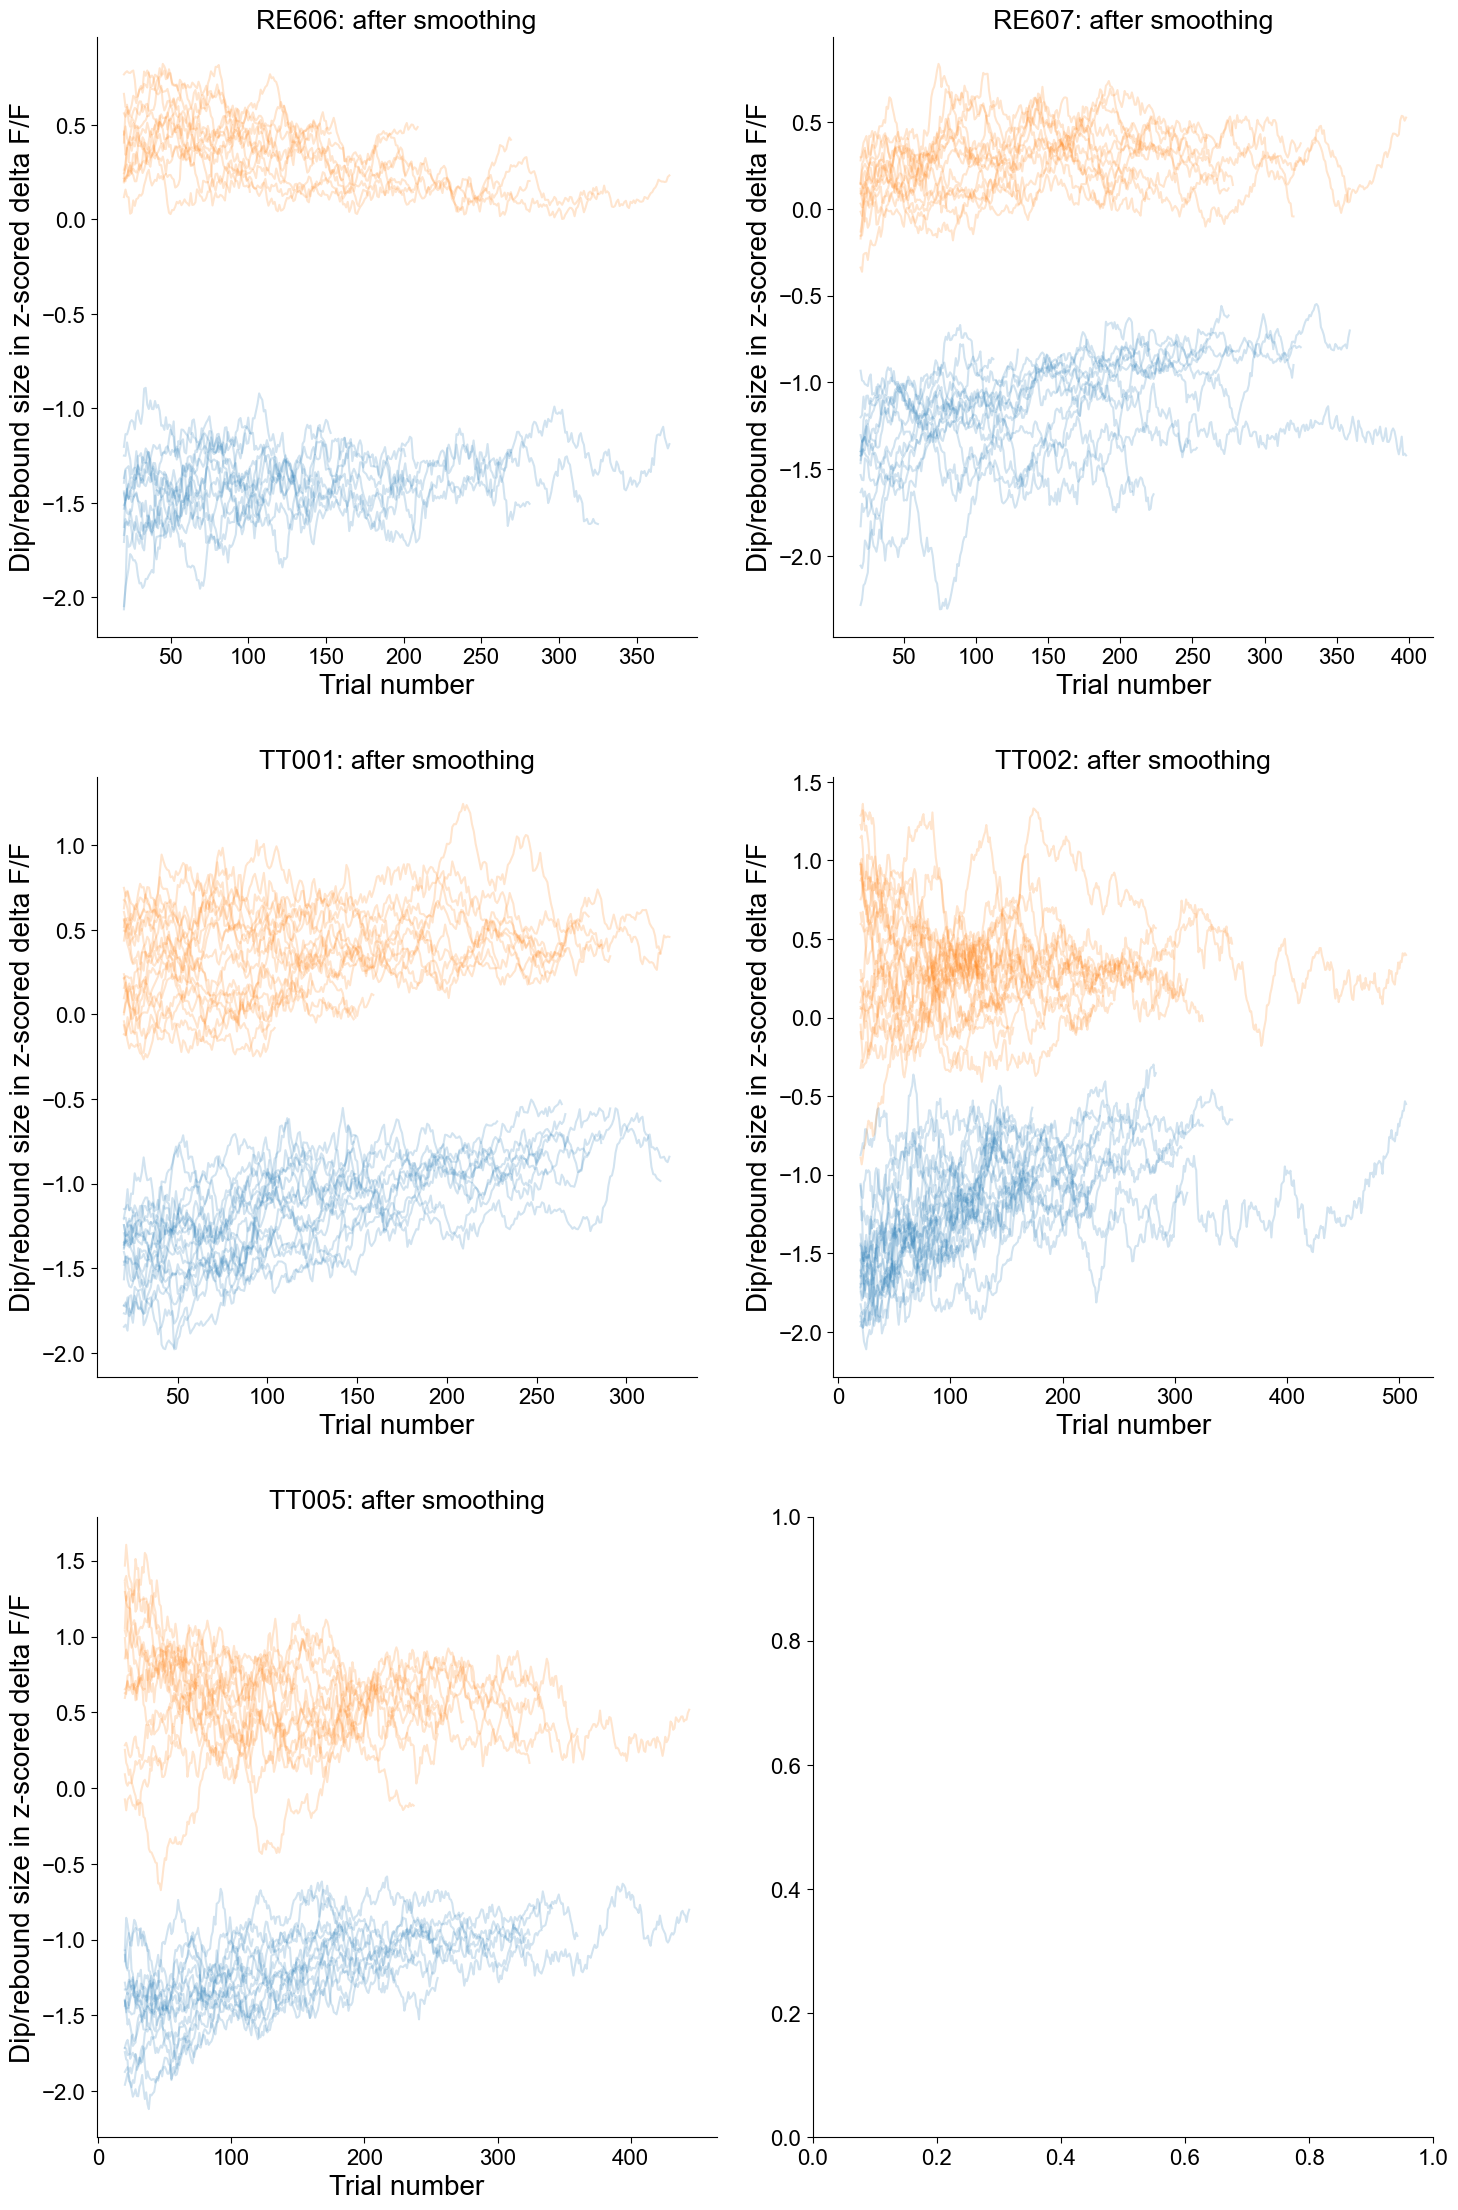

In [ ]:
plt.rcParams['font.size']= 16
plt.rcParams['axes.labelsize'] = 20

subject_ids_ = sorted(list(set(df_ACh_cue_onset_100['subject_id'])))

ax = [None]*6
for j, sbj in enumerate(subject_ids_):

    ax[j] = pw.Brick(figsize=(6, 6))


    ax[j].set_title(sbj + ": after smoothing")

    ind = df_ACh_cue_onset_100.loc[df_ACh_cue_onset_100['subject_id'] == sbj].index

    for i in ind:

        ax[j].plot(df_ACh_cue_onset_100['df_trials'][i]['trial_nb'],
                df_ACh_cue_onset_100['df_trials'][i]['dip_smooth20'], color='#1f77b4', alpha=0.2)
        ax[j].plot(df_ACh_cue_onset_100['df_trials'][i]['trial_nb'],
                df_ACh_cue_onset_100['df_trials'][i]['rebound_smooth20'], color='#ff7f0e', alpha=0.2)

        ax[j].set_xlabel('Trial number')
        ax[j].set_ylabel('Dip/rebound size in z-scored delta F/F')

ax[5] = pw.Brick(figsize=(3, 3))

ax01 = ax[0] | ax[1] 
ax23 = ax[2] | ax[3] 
ax45 = ax[4] | ax[5]
ax0123 = ax01 / ax23
ax012345 = ax0123 / ax45

ax012345.savefig()


- trial_outcome
- cueonset
- spout



In [ ]:
ss_d = df_ACh_cue_onset_100.loc[(df_ACh_cue_onset_100['trial_nb_dip_r_value'] * -1 < -0.3), 'session_id']
ss_d


16     RE607-2023-05-24-103758
19     RE607-2023-05-28-163935
20     RE607-2023-05-30-114301
22     RE607-2023-06-01-130758
28     RE607-2023-06-14-150749
29     RE607-2023-06-19-145200
30     RE607-2023-06-26-125142
31     TT001-2023-05-24-110947
33     TT001-2023-05-26-154430
35     TT001-2023-05-30-145525
37     TT001-2023-06-01-160146
38     TT001-2023-06-02-163605
39     TT001-2023-06-05-161610
40     TT001-2023-06-06-155928
41     TT001-2023-06-07-150956
42     TT001-2023-06-14-142745
52     TT001-2023-06-22-114744
53     TT001-2023-06-23-154127
67     TT002-2023-05-29-133612
68     TT002-2023-05-30-142840
73     TT002-2023-06-05-154932
74     TT002-2023-06-06-152000
75     TT002-2023-06-07-145802
76     TT002-2023-06-08-111737
77     TT002-2023-06-14-144112
78     TT002-2023-06-19-141706
79     TT002-2023-06-22-104448
81     TT002-2023-06-23-144814
82     TT002-2023-06-24-155345
85     TT002-2023-06-28-162538
87     TT002-2023-07-04-124931
89     TT005-2023-05-24-163108
90     T

In [ ]:

ss = 'TT001-2023-06-23-154127'
datadir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22' + '\\' + ss + r'\processed'

xr_photometry = xr.open_dataset(os.path.join(datadir, 'xr_photometry.nc'))
xr_session = xr.open_dataset(os.path.join(datadir, 'xr_session.nc'))


In [ ]:
from scipy.stats import pearsonr
ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

dip_suc = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
    event_time=slice(75, 250), trial_nb=ind_success).min(dim='event_time').values
dip_suc_r, dip_suc_p = pearsonr(dip_suc, np.arange(1, len(dip_suc) +1))


In [ ]:
dip_suc_r


0.3360771411676574

In [ ]:
os.path.isfile(os.path.join(datadir, 'xr_photometry.nc'))

True

In [ ]:

dip_suc = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
    event_time=slice(75, 250), trial_nb=ind_success).min(dim='event_time').values


In [ ]:
#  Calculate CC or slope

from scipy.stats import pearsonr

if 'list_size3' in globals():
    del list_size3

list_size3 = []
for ss in ss_d:

    datadir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22' + '\\' + ss + r'\processed'

    try:
        xr_photometry = xr.open_dataset(os.path.join(datadir, 'xr_photometry.nc'))
        xr_session = xr.open_dataset(os.path.join(datadir, 'xr_session.nc'))
        
        # need to select trials for success and 

        ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

        trial_nbs = xr_session['trial_nb'].values

        xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=ind_success).min(dim='event_time').values


        ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

        dip_suc = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=ind_success).min(dim='event_time').values
        dip_suc = dip_suc[~np.isnan(dip_suc)]
        dip_suc_r, dip_suc_p = pearsonr(-1 * dip_suc, range(1, len(dip_suc) +1))
        # Y could be trial_nb, range(1, len(x) +1), or timestamps of cue

        reb_suc = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(200, 600), trial_nb=ind_success).max(dim='event_time').values
        reb_suc = reb_suc[~np.isnan(reb_suc)]
        reb_suc_r, reb_suc_p = pearsonr(reb_suc, range(1, len(reb_suc) + 1))

        lbo_suc = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(0, 150), trial_nb=ind_success).max(dim='event_time').values
        lbo_suc = lbo_suc[~np.isnan(lbo_suc)]
        lbo_suc_r, lbo_suc_p = pearsonr(lbo_suc, range(1, len(lbo_suc) + 1))

        rew_suc = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(500, 750), trial_nb=ind_success).max(dim='event_time').values
        rew_suc = rew_suc[~np.isnan(rew_suc)]
        rew_suc_r, rew_suc_p = pearsonr(rew_suc, range(1, len(rew_suc) + 1))

        items = [ss, dip_suc, reb_suc, lbo_suc, rew_suc, 
                dip_suc_r, reb_suc_r, lbo_suc_r, rew_suc_r]
    except Exception as e: 
        print(f'{ss}, {e}')
        items = [ss, np.nan, np.nan, np.nan, np.nan, 
                np.nan, np.nan, np.nan, np.nan]

    df_size3 = pd.DataFrame([items])
    df_size3.columns = ['session_id', 'dip_suc', 'reb_suc', 'lbo_suc', 'rew_suc', 
                  'dip_suc_r', 'reb_suc_r', 'lbo_suc_r', 'rew__suc_r']
    list_size3.append(df_size3)




In [ ]:
df_size3_ = pd.concat(list_size3, axis=0)

df_size3_ = df_size3_.dropna(subset=['dip_suc_r'])

df_size3_['subject_id'] = [re.search('\w+', sid).group(0) for sid in df_size3_['session_id']]
df_size3_


,session_id,dip_suc,reb_suc,lbo_suc,rew_suc,dip_suc_r,reb_suc_r,lbo_suc_r,rew__suc_r,subject_id
0,RE607-2023-05-24-103758,"[-1.5888430654192331, -2.0554224764008593, -1....","[1.371049011021404, 2.744419152432657, 4.29646...","[0.019569676480988153, -0.9035066721254641, 4....","[0.8525650116095798, 0.8169466112268373, 1.402...",-0.366311,-0.033068,0.232710,-0.348340,RE607
0,RE607-2023-05-28-163935,"[-3.178141612992852, -1.492044217468297, -0.94...","[3.3730325970633466, 2.3098669027757968, 1.768...","[2.608814903561354, 1.2692911542412053, 0.8078...","[2.1503929101568713, 2.6084582604571405, 2.385...",-0.264068,-0.221058,-0.114045,-0.374263,RE607
0,RE607-2023-05-30-114301,"[-2.4279768769915875, -2.7436404468800952, -1....","[-0.6043260748283817, 0.3716069830287356, 0.62...","[0.6024666488257056, -0.20383141972074115, -0....","[0.6489840789070532, 1.14183720668792, 0.66873...",-0.481630,-0.088128,-0.074553,0.029530,RE607
0,RE607-2023-06-01-130758,"[0.050054861331420494, -1.0088238665185507, -1...","[3.3038137402999097, 1.5930027510761684, 1.788...","[1.1670800298073842, 2.6765905101179355, 0.197...","[1.2583217167944332, 3.045017692226604, 0.9180...",-0.477770,-0.242257,-0.130780,-0.187711,RE607
0,RE607-2023-06-14-150749,"[-1.5064390469368416, -1.34918894414517, -0.71...","[1.0391156474044012, 1.5060828258550996, 2.123...","[1.7798186532798308, 3.384585643856634, 0.7502...","[1.251638675802214, 1.0009203768605939, 2.0428...",-0.462396,-0.379814,-0.315549,-0.085857,RE607
0,RE607-2023-06-19-145200,"[-1.3863861755306375, -1.5443751560365468, -1....","[1.7177759810626563, 2.211475238683708, 0.8186...","[1.7234573093581878, 4.170903013424364, 0.2197...","[0.854068239184254, 2.035873975193859, 3.48786...",-0.414675,-0.262811,-0.247278,-0.021467,RE607
0,RE607-2023-06-26-125142,"[-1.1009220314704211, -1.890810809024331, -2.8...","[6.486549815851488, 1.5757795940272803, 1.4315...","[2.13479563228808, 2.6838436481586574, 4.49077...","[2.7426719030442803, 1.968479551950861, 3.8562...",-0.481762,-0.390607,0.110914,-0.210728,RE607
0,TT001-2023-05-24-110947,"[-1.249412432282945, -0.9321517792482004, -1.7...","[3.264177055147153, 4.556205357328783, 7.99933...","[3.056953737910257, 4.556205357328783, 2.51809...","[-0.9086388128517211, -0.1788331140291302, 0.4...",-0.360626,-0.252796,-0.125313,0.071054,TT001
0,TT001-2023-05-26-154430,"[0.09676423461453051, -2.287136727215785, -1.6...","[8.374993449580034, 2.3586167479746094, 2.7455...","[8.374993449580034, 1.012987799545058, 2.74556...","[0.4533589786961045, 1.6296054079809095, 1.089...",-0.396877,-0.312412,-0.309577,-0.310797,TT001
0,TT001-2023-05-30-145525,"[-2.8431351717288407, -1.3126213097817836, -1....","[0.8552882967009444, 2.701285084096032, 2.9356...","[1.985261111246541, 1.078132124689113, 0.93241...","[1.3314646920148507, 2.1902806178725656, 4.657...",-0.620679,-0.208629,0.022172,-0.151821,TT001


In [46]:
df_size3_


,session_id,dip_suc,reb_suc,lbo_suc,rew_suc,dip_suc_r,reb_suc_r,lbo_suc_r,rew__suc_r,subject_id
0,RE607-2023-05-24-103758,"[-1.5888430654192331, -2.0554224764008593, -1....","[1.371049011021404, 2.744419152432657, 4.29646...","[0.019569676480988153, -0.9035066721254641, 4....","[0.8525650116095798, 0.8169466112268373, 1.402...",-0.366311,-0.033068,0.232710,-0.348340,RE607
0,RE607-2023-05-28-163935,"[-3.178141612992852, -1.492044217468297, -0.94...","[3.3730325970633466, 2.3098669027757968, 1.768...","[2.608814903561354, 1.2692911542412053, 0.8078...","[2.1503929101568713, 2.6084582604571405, 2.385...",-0.264068,-0.221058,-0.114045,-0.374263,RE607
0,RE607-2023-05-30-114301,"[-2.4279768769915875, -2.7436404468800952, -1....","[-0.6043260748283817, 0.3716069830287356, 0.62...","[0.6024666488257056, -0.20383141972074115, -0....","[0.6489840789070532, 1.14183720668792, 0.66873...",-0.481630,-0.088128,-0.074553,0.029530,RE607
0,RE607-2023-06-01-130758,"[0.050054861331420494, -1.0088238665185507, -1...","[3.3038137402999097, 1.5930027510761684, 1.788...","[1.1670800298073842, 2.6765905101179355, 0.197...","[1.2583217167944332, 3.045017692226604, 0.9180...",-0.477770,-0.242257,-0.130780,-0.187711,RE607
0,RE607-2023-06-14-150749,"[-1.5064390469368416, -1.34918894414517, -0.71...","[1.0391156474044012, 1.5060828258550996, 2.123...","[1.7798186532798308, 3.384585643856634, 0.7502...","[1.251638675802214, 1.0009203768605939, 2.0428...",-0.462396,-0.379814,-0.315549,-0.085857,RE607
0,RE607-2023-06-19-145200,"[-1.3863861755306375, -1.5443751560365468, -1....","[1.7177759810626563, 2.211475238683708, 0.8186...","[1.7234573093581878, 4.170903013424364, 0.2197...","[0.854068239184254, 2.035873975193859, 3.48786...",-0.414675,-0.262811,-0.247278,-0.021467,RE607
0,RE607-2023-06-26-125142,"[-1.1009220314704211, -1.890810809024331, -2.8...","[6.486549815851488, 1.5757795940272803, 1.4315...","[2.13479563228808, 2.6838436481586574, 4.49077...","[2.7426719030442803, 1.968479551950861, 3.8562...",-0.481762,-0.390607,0.110914,-0.210728,RE607
0,TT001-2023-05-24-110947,"[-1.249412432282945, -0.9321517792482004, -1.7...","[3.264177055147153, 4.556205357328783, 7.99933...","[3.056953737910257, 4.556205357328783, 2.51809...","[-0.9086388128517211, -0.1788331140291302, 0.4...",-0.360626,-0.252796,-0.125313,0.071054,TT001
0,TT001-2023-05-26-154430,"[0.09676423461453051, -2.287136727215785, -1.6...","[8.374993449580034, 2.3586167479746094, 2.7455...","[8.374993449580034, 1.012987799545058, 2.74556...","[0.4533589786961045, 1.6296054079809095, 1.089...",-0.396877,-0.312412,-0.309577,-0.310797,TT001
0,TT001-2023-05-30-145525,"[-2.8431351717288407, -1.3126213097817836, -1....","[0.8552882967009444, 2.701285084096032, 2.9356...","[1.985261111246541, 1.078132124689113, 0.93241...","[1.3314646920148507, 2.1902806178725656, 4.657...",-0.620679,-0.208629,0.022172,-0.151821,TT001


In [48]:
df_size3__ = df_size3_.loc[:,  ['dip_suc_r', 'reb_suc_r', 'lbo_suc_r', 'rew__suc_r']]

df_melted = df_size3__.melt(var_name='group', value_name='value')


In [56]:
ax.get_xlim()

(-0.5, 0.5)

In [60]:
ax.get_xlim()

(-0.5, 3.469607923635954)

([<matplotlib.axis.XTick at 0x144e5ff1730>,
 [Text(0, 0, 'Cue onset dip'),
  Text(1, 0, 'Cue onset rebound'),
  Text(2, 0, 'Last bar_off peak'),
  Text(3, 0, 'Reward peak')])

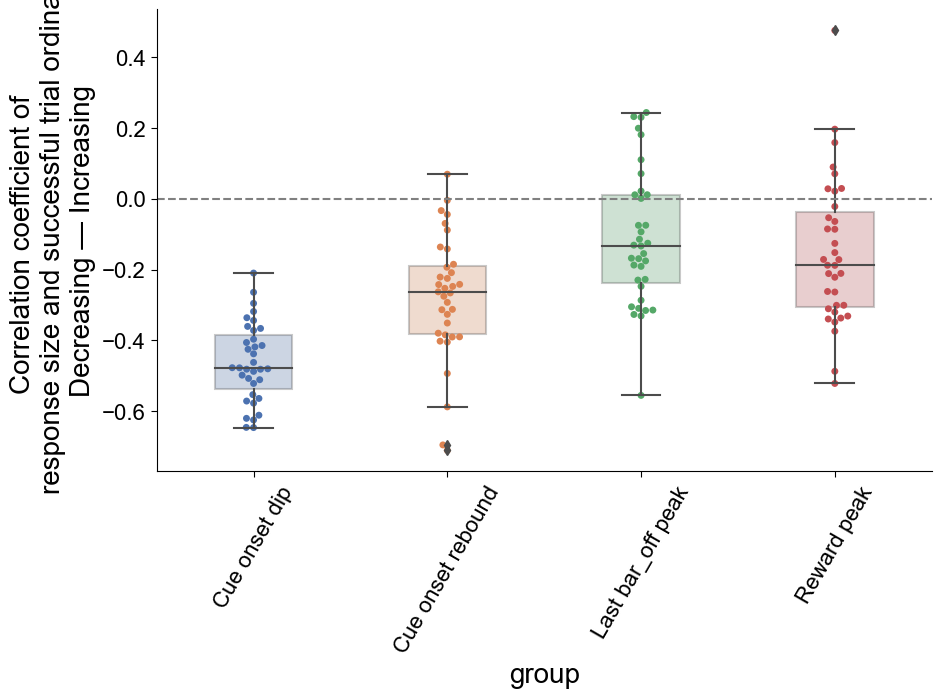

In [62]:
plt.figure(figsize=(10, 6))
palette = sns.color_palette('deep', 4)
sns.swarmplot(x='group', y='value', data=df_melted, palette=palette,
              zorder=1)  # zorder=1 to be underneath the boxplot
# zorder=2 to be over the swarmplot
sns.boxplot(x='group', y='value', data=df_melted, zorder=2,
            boxprops=dict(alpha=.3), palette=palette, width=0.4)
plt.axhline(0, ls='--', color='gray')
plt.ylabel('Correlation coefficient of \nresponse size and successful trial ordinal\nDecreasing — Increasing')
plt.xticks(range(0, 4), ['Cue onset dip', 'Cue onset rebound',
           'Last bar_off peak', 'Reward peak'], rotation=60)


# Early, middle, late .... difficult to get statistical significance because of large variance

In [ ]:

list_size3 = []
for ss in ss_d:

    datadir = r'\\ettina\Magill_Lab\Julien\Data\head-fixed\by_sessions\reaching_go_spout_bar_nov22' + '\\' + ss + r'\processed'

    xr_photometry = xr.open_dataset(os.path.join(datadir, 'xr_photometry.nc'))
    xr_session = xr.open_dataset(os.path.join(datadir, 'xr_session.nc'))
    
    # need to select trials for success and 

    trial_nbs = xr_session['trial_nb'].values

    first_30_index = int(len(trial_nbs) * 0.20)
    last_30_index = int(len(trial_nbs) * 0.80)

    first_30 = trial_nbs[:first_30_index]
    last_30 = trial_nbs[last_30_index:]

    start_middle_45_index = int(len(trial_nbs) * 0.45)
    end_middle_65_index = int(len(trial_nbs) * 0.65)
    middle_30 = trial_nbs[start_middle_45_index:end_middle_65_index]

    ind_success = np.where(xr_session['trial_outcome'].values == 'success')[1] + 1

    first_30_index  = list(set(first_30) & set(ind_success))
    first_30_index.sort()

    middle_30_index  = list(set(middle_30) & set(ind_success))
    middle_30_index.sort()

    last_30_index  = list(set(last_30) & set(ind_success))
    last_30_index.sort()

    if first_30_index: 
        dip_1 = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=first_30_index).min(dim='event_time').values
    else:
        dip_1 = []

    if middle_30_index: 
        dip_2 = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=middle_30_index).min(dim='event_time').values
    else:
        dip_2 = []

    if last_30_index: 
        dip_3 = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(75, 250), trial_nb=last_30_index).min(dim='event_time').values
    else:
        dip_3 = []

    if first_30_index : 
        reb_1 = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(200, 600), trial_nb=first_30_index).max(dim='event_time').values
    else:
        reb_1 = []
    
    if middle_30_index: 
        reb_2 = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(200, 600), trial_nb=middle_30_index).max(dim='event_time').values
    else:
        reb_2 = []

    if last_30_index:
        reb_3 = xr_photometry['hold_for_water_zscored_df_over_f'].sel(
            event_time=slice(200, 600), trial_nb=last_30_index).max(dim='event_time').values
    else:
        dip_3 = []

    if first_30_index:
        lbo_1 = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(0, 150), trial_nb=first_30_index).max(dim='event_time').values
    else:
        lbo_1 = []

    if middle_30_index:
        lbo_2 = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(0, 150), trial_nb=middle_30_index).max(dim='event_time').values
    else:
        lbo_2 = []

    if last_30_index:
        lbo_3 = xr_photometry['last_bar_off_zscored_df_over_f'].sel(
            event_time=slice(0, 150), trial_nb=last_30_index).max(dim='event_time').values
    else:
        lbo_3 = []

    if first_30_index:
        rew_1 = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(500, 750), trial_nb=first_30_index).max(dim='event_time').values
    else:
        rew_1 = []

    if middle_30_index:
        rew_2 = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(500, 750), trial_nb=middle_30_index).max(dim='event_time').values
    else:
        rew_2 = []

    if last_30_index:
        rew_3 = xr_photometry['first_spout_zscored_df_over_f'].sel(
            event_time=slice(500, 750), trial_nb=last_30_index).max(dim='event_time').values
    else:
        rew_3 = []
    
    items = [ss, dip_1, dip_2, dip_3, reb_1, reb_2, reb_3, lbo_1, lbo_2, lbo_3, rew_1, rew_2, rew_3]
    df_size3 = pd.DataFrame([items])
    df_size3.columns = ['session_nb','dip_1' ,'dip_2', 'dip_3', 'reb_1', 'reb_2', 'reb_3',
                  'lbo_1', 'lbo_2', 'lbo_3', 'rew_1', 'rew_2', 'rew_3']
    list_size3.append(df_size3)


KeyboardInterrupt: 

In [ ]:

df_size3 = pd.concat(list_size3, axis=0)


In [ ]:
y = df_size3['dip_1']
y = [item for sublist in df_size3['dip_1'] for item in sublist]


In [ ]:
df_size3.columns

Index(['session_nb', 'dip_suc', 'reb_suc', 'lbo_suc', 'rew_suc', 'dip_suc_r',
       'reb_suc_r', 'lbo_suc_r', 'rew__suc_r'],
      dtype='object')

Text(0, 0.5, 'Response size in z-scored delta F/F')

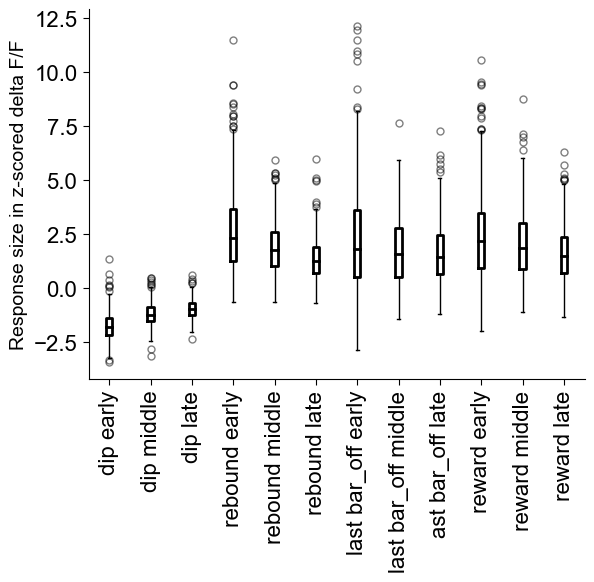

In [ ]:

def plot_one(key, k):
    y = [item for sublist in df_size3[key] for item in sublist]
    y = [x for x in y if not np.isnan(x)]
    # sns.swarmplot(x=1, y=y)
    bp = ax.boxplot(y, positions=[k])


    # Change the box size
    for box in bp['boxes']:
        box.set(linewidth=2)

    # Change the median line color
    for median in bp['medians']:
        median.set(color='black', linewidth=2)

    # Change outlier size
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5, markersize=5)


fig, ax = plt.subplots()

keys = ['dip_1', 'dip_2', 'dip_3', 'reb_1', 'reb_2', 'reb_3',
       'lbo_1', 'lbo_2', 'lbo_3', 'rew_1', 'rew_2', 'rew_3']

for i, key in enumerate(keys):
    plot_one(key, i);

keys2 = ['dip early', 'dip middle', 'dip late', 
         'rebound early', 'rebound middle', 'rebound late',
       'last bar_off early', 'last bar_off middle', 'ast bar_off late',
        'reward early', 'reward middle', 'reward late']
ax.set_xticklabels(keys2)
plt.xticks(rotation=90)  # Adjust font size here
plt.ylabel('Response size in z-scored delta F/F', fontsize=14)


In [ ]:
keys[0:3]


['dip_1', 'dip_2', 'dip_3']

In [ ]:
from scipy import stats
from scipy.stats import mannwhitneyu


def stats2(keys):
    y1= [item for sublist in df_size3[keys[0]] for item in sublist]
    y1 = [x for x in y1 if not np.isnan(x)]

    # y2= [item for sublist in df_size3[keys[1]] for item in sublist]
    # y2 = [x for x in y1 if not np.isnan(x)]

    y3= [item for sublist in df_size3[keys[2]] for item in sublist]
    y3 = [x for x in y1 if not np.isnan(x)]



    # sns.swarmplot(x=1, y=y)
    stat, p = mannwhitneyu(y1, y3)

    print(stat)
    print(p)

stats2(keys[0:3])
stats2(keys[3:6])
stats2(keys[6:9])
stats2(keys[9:12])


158484.5
1.0
158484.5
1.0
144722.0
1.0
158484.5
1.0


I guess this is because there are so much variance due to the noisy nature of the data.